# Lexis Date Parser

This script normalizes dates from LexisUni and visualizes attention across outlets over time.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows


In [2]:
# Stap 1: Bestanden inlezen en hyperlinks extraheren
directory = "data/"
files = [f for f in os.listdir(directory) if f.endswith(".XLSX")]
all_data = []

for file in files:
    file_path = os.path.join(directory, file)
    try:
        # Laad het Excel-bestand met openpyxl
        wb = load_workbook(file_path, data_only=True)
        sheet = wb.active  # Gebruik het actieve werkblad

        # Lees de data in met pandas
        df = pd.read_excel(file_path, engine='openpyxl')
        
        # Controleer of de 'Title'-kolom bestaat en lees hyperlinks
        if 'Titel' in df.columns:
            # Zoek de kolomindex van 'Title'
            title_col_idx = df.columns.get_loc('Titel') + 1  # Openpyxl gebruikt 1-based index

            # Lees hyperlinks uit de juiste kolom
            hyperlinks = []
            for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row, min_col=title_col_idx, max_col=title_col_idx):
                cell = row[0]
                hyperlink = cell.hyperlink.target if cell.hyperlink else None
                hyperlinks.append(hyperlink)
            
            # Voeg de 'Hyperlink' kolom toe aan de dataframe
            df['Hyperlink'] = hyperlinks
        else:
            # Voeg een lege kolom toe als 'Title' niet bestaat
            df['Hyperlink'] = None
        
        df['Source'] = file  # Voeg de bestandsnaam als bron toe
        all_data.append(df)
        print(f"Loaded {file} with {df.shape[0]} rows and {df.shape[1]} columns")
    
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combineer alle dataframes
combined_df = pd.concat(all_data, ignore_index=True)


Loaded AD 2022-2023 hele sample.XLSX with 410 rows and 23 columns
Loaded AD 2019-2021 hele sample.XLSX with 462 rows and 23 columns
Loaded Volkskrant 2019-2021 hele sample.XLSX with 353 rows and 23 columns
Loaded Volkskrant 2022-2024 bijna hele sample.XLSX with 0 rows and 23 columns
Loaded Telegraaf 2022-2024 hele sample.XLSX with 396 rows and 23 columns
Loaded NRC 2022-2024 hele sample.XLSX with 487 rows and 23 columns
Loaded AD 2024 hele sample.XLSX with 166 rows and 23 columns
Loaded Volkskrant 2022-2024 201-500.XLSX with 300 rows and 23 columns
Loaded Volkskrant 2022-2024 einde sample laatste 16.XLSX with 16 rows and 23 columns
Loaded Telegraaf 2019-2021 hele sample.XLSX with 217 rows and 23 columns
Loaded NRC 2019-2021 hele sample.XLSX with 366 rows and 23 columns
Loaded Volkskrant 2022-2024 1-200.XLSX with 200 rows and 23 columns


In [3]:
# Function to normalize date format
def normalize_datum(date_str):
   
    month_translation = {
        "januari": "January", "februari": "February", "maart": "March", "april": "April",
        "mei": "May", "juni": "June", "juli": "July", "augustus": "August", "september": "September",
        "oktober": "October", "november": "November", "december": "December"
    }
    
    for dutch, english in month_translation.items():
        date_str = date_str.replace(dutch, english)

    date_str = " ".join(word for word in date_str.split() if not word.isalpha() or word in month_translation.values())
    return parse(date_str, dayfirst=True).date()

combined_df["Datum"] = combined_df["Datum"].apply(normalize_datum)

combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])
print(combined_df["Datum"])

0      2022-01-09
1      2022-01-09
2      2022-01-09
3      2022-01-10
4      2022-01-12
          ...    
3368   2023-01-31
3369   2023-02-01
3370   2023-02-08
3371   2023-02-08
3372   2023-02-09
Name: Datum, Length: 3373, dtype: datetime64[ns]


In [4]:
publication_map = {
    'AD/Algemeen Dagblad.nl': 'Algemeen Dagblad',
    'AD/Algemeen Dagblad': 'Algemeen Dagblad',
    'de Volkskrant': 'Volkskrant',
    'De Volkskrant.nl': 'Volkskrant',
    'De Telegraaf.nl': 'Telegraaf',
    'De Telegraaf': 'Telegraaf',
    'NRC.nl': 'NRC',
    'NRC Handelsblad': 'NRC',
    'NRC': 'NRC'
}

# Normalize the 'Publicatie' column using the mapping
combined_df['Publicatie_unique'] = combined_df['Publicatie'].replace(publication_map)
# Check the unique values after normalization
print(combined_df['Publicatie'].unique())

['AD/Algemeen Dagblad.nl' 'AD/Algemeen Dagblad' 'de Volkskrant'
 'De Volkskrant.nl' 'De Telegraaf.nl' 'De Telegraaf' 'NRC.nl'
 'NRC Handelsblad' 'NRC']


## Visualize

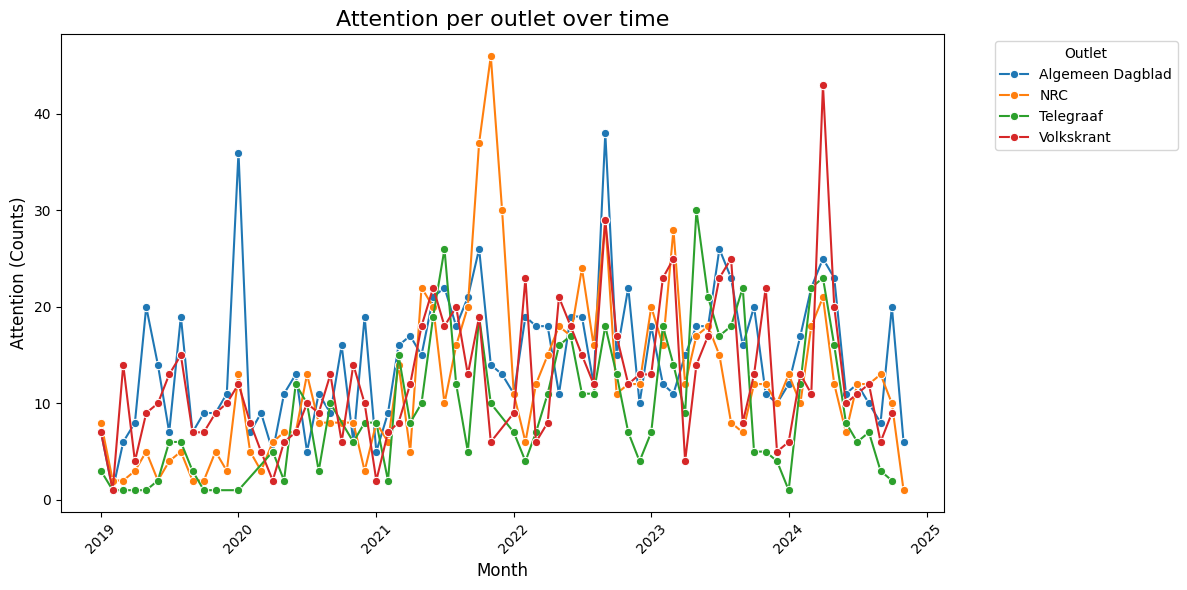

In [5]:

aggregated_df = combined_df.groupby(['Datum', 'Publicatie_unique']).size().reset_index(name='Attention')
aggregated_df['Month'] = aggregated_df['Datum'].dt.to_period('M').dt.to_timestamp()
monthly_df = aggregated_df.groupby(['Month', 'Publicatie_unique'])['Attention'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_df, x='Month', y='Attention', hue='Publicatie_unique', marker='o')

plt.title('Attention per outlet over time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Attention (Counts)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

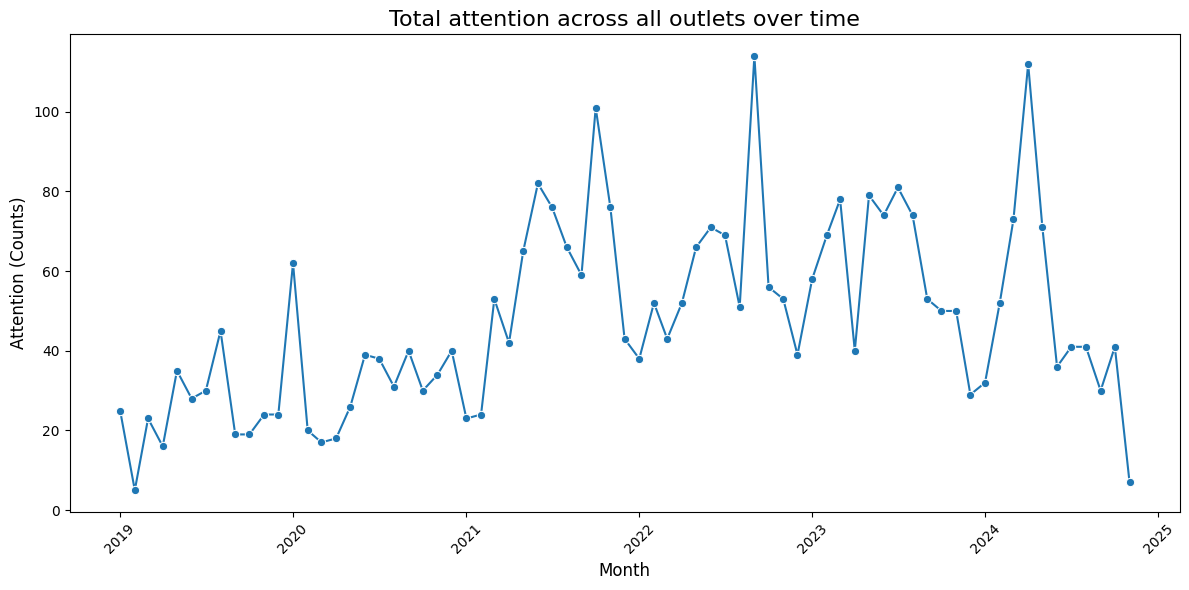

In [6]:
combined_attention_df = aggregated_df.groupby('Month')['Attention'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_attention_df, x='Month', y='Attention', marker='o')

plt.title('Total attention across all outlets over time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Attention (Counts)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
combined_df[["Publicatie", "Datum"]].head()

,Publicatie,Datum
0,AD/Algemeen Dagblad.nl,2022-01-09
1,AD/Algemeen Dagblad.nl,2022-01-09
2,AD/Algemeen Dagblad.nl,2022-01-09
3,AD/Algemeen Dagblad.nl,2022-01-10
4,AD/Algemeen Dagblad.nl,2022-01-12


In [8]:
combined_df.to_csv("data/normalized_data/normalized_dates.csv", index=False, encoding="utf-8")
combined_df.to_excel("data/normalized_data/normalized_dates.xlsx", index=False, engine="openpyxl")

# Final sampling strategy: Constructed Year, stratefied by Month/ Outlet


this script implements a **stratified sampling strategy** to ensure a fair and balanced selection of articles over time. the main idea is to maintain representation across **months** and **outlets**, preventing over- or under-representation of certain periods or sources.  

## overall strategy  

instead of randomly selecting articles from the entire dataset, the script first **groups** the data by **month (`YearMonth`) and outlet (`Publicatie_unique`)**. within each group, it selects **up to two articles**. if a particular month-outlet combination has only one article, it includes that single article. if there are no articles, nothing is sampled. this ensures that every outlet contributes proportionally over time, making the dataset more **balanced and representative**.  

after constructing this **"sampled year" dataset**, the script takes a **secondary sample** for an **intercoder reliability test**. this is a subset of **up to 55 randomly selected articles** from the stratified dataset. this training set helps in evaluating **coding consistency** among researchers analyzing the articles.  

## detailed steps  

### 1. grouping the dataset  
- the script starts by **grouping** articles based on their publication **month (`YearMonth`)** and **outlet (`Publicatie_unique`)**.  
- each group contains all articles from a given **outlet in a specific month**.  

### 2. sampling within each group  
- within each **month-outlet** group, the script tries to sample **two articles**.  
- if the group contains **two or more articles**, two are randomly selected.  
- if there is **only one article**, it is included.  
- if there are **no articles**, nothing is added for that group.  

### 3. combining the selected samples  
- all sampled articles from different groups are combined into a new dataset, representing the **stratified sample across time and sources**.  

### 4. removing unnecessary columns  
- after sampling, the `YearMonth` column is removed to keep the dataset clean.  

### 5. creating the intercoder reliability training set  
- a **secondary sample** of up to **55 randomly selected articles** is taken from the stratified dataset.  
- if fewer than 55 articles exist, all are included.  
- this sample is used for **intercoder reliability testing**, ensuring that different researchers classify articles consistently.  

### 6. saving the dataset  
- the full **stratified sample** is saved as **csv** and **excel**.  
- if the dataset contains hyperlinks, they are **retained in the excel file**.  

### 7. error handling and validation  
- before running, the script checks if `combined_df` exists and contains the required columns (`YearMonth`, `Publicatie_unique`).  
- if these columns are missing, it stops execution and alerts the user.  
- if no articles are sampled, it avoids errors and informs the user.  

## why this strategy?  

this stratified approach ensures that:  
- no single outlet or period dominates the dataset.  
- every outlet is represented fairly across months.  
- the dataset is well-distributed for analysis.  
- the intercoder reliability test set is drawn from a **structured** rather than a completely random dataset.  

In [9]:

# Convert "Datum" to datetime format
combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])

# Extract YearMonth for grouping (e.g., '2023-05' for May 2023)
combined_df["YearMonth"] = combined_df["Datum"].dt.to_period("M")

# Add a unique identifier for each news article
combined_df["Article_ID"] = range(1, len(combined_df) + 1)

# Function to sample up to two articles per outlet per month
def sample_constructed_year(df):
    sampled_days = []
    
    # Group by YearMonth and unique outlet
    for (year_month, publicatie_unique), group in df.groupby(["YearMonth", "Publicatie_unique"]):
        n_articles = min(2, len(group))  # If less than 2, sample whatever is available
        monthly_sample = group.sample(n=n_articles, random_state=42, replace=False)
        sampled_days.append(monthly_sample)
    
    return pd.concat(sampled_days, ignore_index=True) if sampled_days else pd.DataFrame()

# Ensure combined_df exists and has the required columns
required_columns = {"YearMonth", "Publicatie_unique"}
if 'combined_df' in locals() and required_columns.issubset(combined_df.columns):
    # Apply the function
    constructed_year_df = sample_constructed_year(combined_df)

    if not constructed_year_df.empty:
        # Drop YearMonth column for clarity
        constructed_year_df = constructed_year_df.drop(columns=["YearMonth"], errors='ignore')

        # Sample 10% (or 55 articles, whichever is smaller) for reliability test
        sample_size = min(55, len(constructed_year_df))
        trainingset_df = constructed_year_df.sample(n=sample_size, random_state=42)

        print(f"Total sampled items (constructed year): {constructed_year_df.shape[0]}")
        print(f"Total sampled items (training set): {trainingset_df.shape[0]}")

        # Define file paths
        output_path = "data/normalized_data/constructed_year.xlsx"
        csv_output_path = "data/normalized_data/constructed_year.csv"

        # Save to CSV
        constructed_year_df.to_csv(csv_output_path, index=False)
        print(f"Sampled data saved in {csv_output_path}")

        # Save to Excel with hyperlinks
        wb = Workbook()
        ws = wb.active

        # Write headers
        ws.append(constructed_year_df.columns.tolist())

        # Write data
        for row in dataframe_to_rows(constructed_year_df, index=False, header=False):
            ws.append(row)

        # Add hyperlinks if present
        if 'Hyperlink' in constructed_year_df.columns:
            for row_idx, link in enumerate(constructed_year_df['Hyperlink'], start=2):
                if pd.notna(link):
                    ws[f"A{row_idx}"].hyperlink = link
                    ws[f"A{row_idx}"].style = "Hyperlink"

        # Save Excel file
        wb.save(output_path)
        print(f"Sampled data with hyperlinks saved in {output_path}")

        # Save training set
        trainingset_df.to_csv("data/normalized_data/training_set_sample.csv", index=False)
        trainingset_df.to_excel("data/normalized_data/training_set_sample.xlsx", index=False)
        print("Training set saved as CSV and Excel.")
    else:
        print("No articles were sampled.")
else:
    print("Error: combined_df is missing or does not have the required columns.")


Total sampled items (constructed year): 541
Total sampled items (training set): 55
Sampled data saved in data/normalized_data/constructed_year.csv
Sampled data with hyperlinks saved in data/normalized_data/constructed_year.xlsx
Training set saved as CSV and Excel.
